In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import datetime
import functions_hiwi as fct
import warnings
import xarray as xr
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
import Korrektur_Emscher as ke

In [2]:
# set ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
# set main directory
main_dir = r'C:\Users\illic\Python\data_hiwi\Emschergenossenschaft'

In [4]:
# set path to data
emscher_path = os.path.join(main_dir, r'EGLV_PWS_dataset_5min_v03.nc')
emscher_ref_1_path = os.path.join(main_dir, r'EGLV_refenzdaten\EGLV_rs_1min.nc')
emscher_ref_5_path = os.path.join(main_dir, r'EGLV_refenzdaten\EGLV_rs_5min2.nc')
emscher_ref_60_path = os.path.join(main_dir, r'EGLV_refenzdaten\EGLV_rs_60min.nc')

In [5]:
# read data
ds_emscher = xr.open_dataset(emscher_path)
ds_emscher_ref_1 = xr.open_dataset(emscher_ref_1_path)
ds_emscher_ref_5 = xr.open_dataset(emscher_ref_5_path)
ds_emscher_ref_60 = xr.open_dataset(emscher_ref_60_path)

In [6]:
# id neu setzen
id = np.arange(1, len(ds_emscher.id) + 1, 1) # oder: id = ['id_' + str(id) for id in (np.arange(1, len(ds_emscher.id) + 1, 1))]
ds_emscher['id'] = id
id = np.arange(1, len(ds_emscher_ref_1.id) + 1, 1)
ds_emscher_ref_1['id'] = id
ds_emscher_ref_5['id'] = id
ds_emscher_ref_60['id'] = id

In [7]:
ds_emscher.time

<xarray.DataArray 'time' (time: 1021338)>
array(['2014-04-26T16:30:00.000000000', '2014-04-26T16:35:00.000000000',
       '2014-04-26T16:40:00.000000000', ..., '2024-01-10T23:45:00.000000000',
       '2024-01-10T23:50:00.000000000', '2024-01-10T23:55:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2014-04-26T16:30:00 ... 2024-01-10T23:55:00
Attributes:
    unit:     seconds since 1970-01-01 00:00:00

In [8]:
ds_emscher_ref_5.sel(id=70).time

<xarray.DataArray 'time' (time: 526087)>
array(['2016-11-01T07:30:00.000000000', '2016-11-01T07:35:00.000000000',
       '2016-11-01T07:40:00.000000000', ..., '2021-11-01T23:50:00.000000000',
       '2021-11-01T23:55:00.000000000', '2021-11-02T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    id         int32 70
    elevation  float64 ...
    y          int64 ...
    x          int64 ...
  * time       (time) datetime64[ns] 2016-11-01T07:30:00 ... 2021-11-02
Attributes:
    unit:     seconds since 1970-01-01 00:00:00

In [9]:
# create DataFrame
df_emscher = pd.DataFrame(data=ds_emscher.rainfall.sel(id=slice(1, 10)).values.T, index=ds_emscher.time.values ,columns=ds_emscher.id.sel(id=slice(1, 10)).values)

# create DataFrame with no NaN values
df_emscher_nonan = df_emscher.fillna(0)

In [10]:
# create DataFrame with coordinates
df_coordinaten_emscher = pd.DataFrame(data=(ds_emscher.lon.values, ds_emscher.lat.values), index=['lon', 'lat'], columns=ds_emscher.id.values).T
coordinates_primary_utm32 = pd.DataFrame(data=(ds_emscher_ref_1.x.values, ds_emscher_ref_1.y.values), index=['lon', 'lat'], columns=ds_emscher_ref_1.id.values).T
# coordinates_primary_utm32 = coordinates_primary_utm32.astype(float)

In [11]:
# transform coordinates to x, y

# x, y = fct.LatLon_To_XY(primary_locations_df['lon'], primary_locations_df['lat'])
# coordinates_primary_utm32 = pd.DataFrame({'lon': x, 'lat': y}, index=primary_locations_df.index)

x, y = fct.LatLon_To_XY(df_coordinaten_emscher['lon'], df_coordinaten_emscher['lat'])
coordinates_secondary_utm32 = pd.DataFrame({'lon': x, 'lat': y}, index=df_coordinaten_emscher.index)

In [12]:
# # set negative values of df to NaN
# cond_1min = PluvioDataRT_ds.rainfall < 0 # True wenn condition erfüllt
# cond_1h = PluvioDataRT_1h_ds.rainfall < 0

# PluvioDataRT_ds = PluvioDataRT_ds.where(~cond_1min) # da wo True, also condition erfüllt ist, wird NaN gesetzt
# PluvioDataRT_1h_ds = PluvioDataRT_1h_ds.where(~cond_1h)

In [13]:
# # create DataFrame
# PluvioDataRT_df = pd.DataFrame(data=PluvioDataRT_ds.rainfall.values.T, index=PluvioDataRT_ds.time.values ,columns=PluvioDataRT_ds.id.values)
# PluvioDataRT_1h_df = pd.DataFrame(data=PluvioDataRT_1h_ds.rainfall.values, index=PluvioDataRT_1h_ds.time.values ,columns=PluvioDataRT_1h_ds.id.values)

In [14]:
def coordinates_all_stations_in_range_mit_primary(loc_prim, loc_sec, type_station, station, frame, geo, radius, ref_df, primary_found):

    # name plot
    name_plot = 'Plot Primär-/Sekundärnetzwerk: ' + type_station + 'station Nr. ' + str(station)

    # beide Netzwerke plotten
    plt.scatter(x=loc_sec['lon'], y=loc_sec['lat'], s=10, label='PWS')
    plt.scatter(x=loc_prim['lon'], y=loc_prim['lat'], s=30, color='black', marker='x', label='Primärstationen')

    # ausgewählte Station plotten
    if type(station) == int:
        if type_station == 'Primär':
            plt.scatter(loc_prim['lon'].loc[station], loc_prim['lat'].loc[station], color='red', label='Ausgewählte Station')
        elif type_station == 'Sekundär':
            plt.scatter(loc_sec['lon'].loc[station], loc_sec['lat'].loc[station], color='red', label='Ausgewählte Station')
            
            # Referenzstationen plotten
            if primary_found:
                plt.scatter(loc_prim['lon'].loc[ref_df.index[0]], loc_prim['lat'].loc[ref_df.index[0]], color='lime', s=30, marker='x', label='Primärreferenzstatoin(-en)')
                for station_ref in ref_df.index[1:]:
                    plt.scatter(loc_prim['lon'].loc[station_ref], loc_prim['lat'].loc[station_ref], color='lime', s=30, marker='x')
            else:
                plt.scatter(loc_sec['lon'].loc[ref_df.index[0]], loc_sec['lat'].loc[ref_df.index[0]], color='lime', s=10, label='PWS-Referenzstation(-en)')
                for station_ref in ref_df.index[1:]:
                    plt.scatter(loc_sec['lon'].loc[station_ref], loc_sec['lat'].loc[station_ref], color='lime', s=10)

    # plotte Kreis
    if geo == 'circle':
        kreis = Circle((loc_sec['lon'].loc[station], loc_sec['lat'].loc[station]), radius=radius, color='black', linewidth=0.5, fill=False)
        plt.gca().add_patch(kreis)

    plt.axis('equal')

    # Anzeigebereich festlegen
    if type(frame) == int:
        try:
            plt.xlim(loc_sec['lon'].loc[station] - frame, loc_sec['lon'].loc[station] + frame)
        except:
            if ((loc_sec['lon'].loc[station] - frame) < loc_sec['lon'].min()):
                plt.xlim(loc_sec['lon'].min(), loc_sec['lon'].loc[station] + frame)
            if ((loc_sec['lon'].loc[station] + frame) > loc_sec['lon'].max()):
                plt.xlim(loc_sec['lon'].loc[station] - frame, loc_sec['lon'].max())
        try:
            plt.ylim(loc_sec['lat'].loc[station] - frame, loc_sec['lat'].loc[station] + frame)
        except:
            if ((loc_sec['lat'].loc[station] - frame) < loc_sec['lat'].min()):
                plt.ylim(loc_sec['lat'].min(), loc_sec['lat'].loc[station] + frame)
            if ((loc_sec['lat'].loc[station] + frame) > loc_sec['lat'].max()):
                plt.ylim(loc_sec['lat'].loc[station] - frame, loc_sec['lat'].max())
    else:
        pass
    
    plt.legend()
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title(name_plot)

    plt.show()
    plt.close()
    
    return

In [15]:
def find_all_stations_in_range(loc_prim, loc_sec, station, frame, radius, plot=True):

    # finde stationen, die innerhalb eines bestimmten Bereich um die Station liegen

    # koordinaten der station
    lon_station = loc_sec['lon'].loc[station]
    lat_station = loc_sec['lat'].loc[station]

    list_reference_stations_lon = []
    list_reference_stations_lat = []
    list_station = []
    list_distance = []
    list_type_station = []

    # check, ob Primärreferenz innerhalb Radius
    primary_found = False

    for i in loc_prim.index:
        lon = loc_prim['lon'].loc[i]
        lat = loc_prim['lat'].loc[i]
        if (np.sqrt((lon - lon_station)**2 + (lat - lat_station)**2) <= radius):

            distance = round(np.sqrt((lon - lon_station)**2 + (lat - lat_station)**2), 2)
                    
            list_distance.append(distance)
            list_station.append(i)
            list_reference_stations_lon.append(round(lon, 2))
            list_reference_stations_lat.append(round(lat, 2))

    if list_station:
        primary_found = True

    # finde die nächsten PWS, wenn keine Primärreferenz gefunden wurde
    if primary_found:
        pass
    else:
        for i in loc_sec.index:
            lon = loc_sec['lon'].loc[i]
            lat = loc_sec['lat'].loc[i]
            if (np.sqrt((lon - lon_station)**2 + (lat - lat_station)**2) <= radius):
                if lon == lon_station and lat == lat_station:
                    pass
                else:
                    distance = round(np.sqrt((lon - lon_station)**2 + (lat - lat_station)**2), 2)
                    
                    list_distance.append(distance)
                    list_station.append(i)
                    list_reference_stations_lon.append(round(lon, 2))
                    list_reference_stations_lat.append(round(lat, 2))
        
    array_reference_stations = np.array([list_reference_stations_lon, list_reference_stations_lat, list_distance]).T
    df_reference_stations = pd.DataFrame(array_reference_stations, columns=['lon', 'lat', 'distance'], index=list_station)

    if plot:
        coordinates_all_stations_in_range(loc_prim, loc_sec, 'Sekundär', station, frame, 'circle', radius, df_reference_stations, primary_found)
       
    return df_reference_stations

In [16]:
# df_reference_stations = find_all_stations_in_range(coordinates_primary_utm32, coordinates_secondary_utm32, 70, 8000, 7500, plot=False)
# df_reference_stations

In [17]:
# df_reference_stations = ke.berechnung_gewichte_emscher(df_reference_stations)
# df_reference_stations

In [18]:
# df_emscher_s70 = pd.DataFrame(data=ds_emscher.rainfall.sel(id=70).values, index=ds_emscher.time.values, columns=[70])
# df_emscher_nonan_s70 = df_emscher_s70.fillna(0)

In [19]:
# df_emscher_ref_5_s82 = pd.DataFrame(data=ds_emscher_ref_5.rainfall.sel(id=82).values, index=ds_emscher_ref_5.time.values, columns=[82])
# df_emscher_ref_5_nonan_s82 = df_emscher_ref_5_s82.fillna(0)

In [20]:
# starts_nan_seq_mit_peak, peaks_mit_nan_seq = ke.get_data_nan_seq_before_peak_new(df_emscher_s70, 70, 0.99)

In [21]:
# df_reference_values = ke.berechnung_referenzniederschlag_emscher(df_reference_stations, df_emscher_s70, df_emscher_ref_5_nonan_s82, 70, starts_nan_seq_mit_peak, peaks_mit_nan_seq)

In [22]:
# df_reference_values

In [23]:
# data_corrected = ke.correct_data_new_emscher(df_emscher_s70, df_reference_values, 70, starts_nan_seq_mit_peak, peaks_mit_nan_seq)

In [24]:
# starts_nan_seq_mit_peak, peaks_mit_nan_seq = ke.get_data_nan_seq_before_peak_new(data_corrected, 70, 0.99)

In [25]:
# len(starts_nan_seq_mit_peak)

In [26]:
# df_emscher

In [27]:
def get_statistics_emscher(data_uncorrected, data_corrected):

    list_nans_gesamt = []
    list_nan_sequences = []
    list_nan_sequences_1_2 = []
    list_nan_sequences_1_2_corr = []
    list_peaks_u = []
    list_peaks = []
    list_nans_gesamt_corr = []
    list_nan_sequences_corr = []
    list_verhaeltnis_nans = []
    list_verhaeltnis_nan_sequences = []

    for station in data_corrected.columns:
        sum_nan_u = data_uncorrected[station].isna().sum()
        list_u = fct.list_nan_sequences_schnell(data_uncorrected, station, '5min')[2]
        x_u, y_u = np.unique(list_u, return_counts=True)
        peaks_u = ke.get_data_nan_seq_before_peak_new(data_uncorrected, station, 0.99)[1]

        # print(station, 'unkorrigiert')
        # print('   nans gesamt: ', sum_nan_u)
        # print('   nan sequenzen: ', y_u.sum())
        # print('   davon 1er und 2er nan sequenzen: ', y_u[0:2].sum())
        # print('   peaks: ', len(peaks_u))

        list_nans_gesamt.append(sum_nan_u)
        list_nan_sequences.append(y_u.sum())
        list_nan_sequences_1_2.append(y_u[0:2].sum())
        list_peaks_u.append(len(peaks_u))

        sum_nan = data_corrected[station].isna().sum()
        list = fct.list_nan_sequences_schnell(data_corrected, station, '5min')[2]
        x, y = np.unique(list, return_counts=True)
        peaks = ke.get_data_nan_seq_before_peak_new(data_corrected, station, 0.99)[1]

        # print(station, 'korrigiert')
        # print('   nans gesamt: ', sum_nan)
        # print('   nan sequenzen: ', y.sum())
        # print('Verhältnis korrigiert zu unkorrigiert: ', round(((sum_nan_u - sum_nan)/sum_nan_u)*100, 2), '% werden korrigiert')

        list_nans_gesamt_corr.append(sum_nan)
        list_nan_sequences_corr.append(y.sum())
        list_verhaeltnis_nans.append(round(((sum_nan_u - sum_nan)/sum_nan_u)*100))
        list_verhaeltnis_nan_sequences.append(round(((y_u.sum() - y.sum())/y_u.sum())*100))
        list_peaks.append(len(peaks))
        list_nan_sequences_1_2_corr.append(y[0:2].sum())

    df_emscher_statistik = pd.DataFrame(index=['NaNs gesamt', 'NaN-Sequenzen', '1er und 2er NaN-Sequenzen', 'Peaks', '--------------------------------------------------', 'NaNs nach Korrektur', 'NaN-Sequenzen nach Korrektur', '1er und 2er NaN-Sequenzen nach Korrektur', 'Peaks nach Korrektur', '--------------------------------------------------', '% NaNs korrigiert', '% NaN-Sequenzen korrigiert'], data=[list_nans_gesamt, list_nan_sequences, list_nan_sequences_1_2, list_peaks_u, [], list_nans_gesamt_corr, list_nan_sequences_corr, list_nan_sequences_1_2_corr, list_peaks, [], list_verhaeltnis_nans, list_verhaeltnis_nan_sequences], columns=data_corrected.columns)
    df_emscher_statistik = df_emscher_statistik.fillna('')

    return df_emscher_statistik

In [29]:
df_emscher_70 = pd.DataFrame(data=ds_emscher.rainfall.sel(id=70).values.T, index=ds_emscher.time.values, columns=[70])
df_emscher_70_nonan = df_emscher_70.fillna(0)
df_emscher_ref = pd.DataFrame(data=ds_emscher_ref_5.rainfall.sel(id=82).values.T, index=ds_emscher_ref_5.time.values, columns=[82])
df_emscher_ref_nonan = df_emscher_ref.fillna(0)

In [30]:
def correction_emscher_complete_mit_primary(loc_prim, loc_sec, data_sec, data_prim_nonan, data_sec_nonan, station_zahl, frame, radius, quantile, plot=False, correct_peak=True, correct_1_2=True, correct_0_pres_ref=True):
    df_reference_stations, primary_found = ke.find_all_stations_in_range_mit_primary(loc_prim, loc_sec, station_zahl, frame, radius, plot)
    # print('df reference stations', '\n', df_reference_stations, '\n', 'primary found: ', primary_found)
    if df_reference_stations.empty:
        print('No reference stations found within radius')
        return
    df_reference_stations = ke.berechnung_gewichte_emscher(df_reference_stations)
    # print('\n')
    # print('df reference stations mit gewichten', '\n', df_reference_stations)
    starts_nan_seq_mit_peak, peaks_mit_nan_seq = ke.get_data_nan_seq_before_peak_new(data_sec, station_zahl, quantile)
    # print('\n')
    # print('starts_nan_seq_mit_peak: ', len(starts_nan_seq_mit_peak), '\n', 'peaks_mit_nan_seq: ', len(peaks_mit_nan_seq))
    df_reference_values = ke.berechnung_referenzniederschlag_emscher_mit_primary(df_reference_stations, data_sec, data_prim_nonan, data_sec_nonan, station_zahl, starts_nan_seq_mit_peak, peaks_mit_nan_seq, primary_found)
    # print('\n')
    # print('df reference values', '\n', df_reference_values)
    data_corrected = ke.correct_data_new_emscher(data_sec, df_reference_values, station_zahl, starts_nan_seq_mit_peak, peaks_mit_nan_seq, correct_peak, correct_1_2, correct_0_pres_ref)
    # print('\n')
    # print('data corrected', '\n', data_corrected)

    return df_reference_stations, df_reference_values, data_corrected

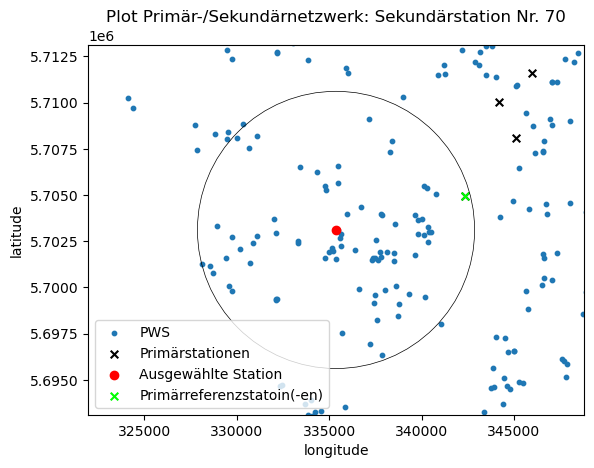

,70
NaNs gesamt,419353.0
NaN-Sequenzen,13424.0
1er und 2er NaN-Sequenzen,11290.0
Peaks,315.0
--------------------------------------------------,
NaNs nach Korrektur,363429.0
NaN-Sequenzen nach Korrektur,2091.0
1er und 2er NaN-Sequenzen nach Korrektur,722.0
Peaks nach Korrektur,58.0
--------------------------------------------------,


In [31]:
df_reference_stations_p, df_reference_values_p, data_corrected_p = correction_emscher_complete_mit_primary(coordinates_primary_utm32, coordinates_secondary_utm32, df_emscher_70, df_emscher_ref_nonan, df_emscher_70_nonan, 70, 10000, 7500, 0.99, True)
df_reference_stations_p
get_statistics_emscher(df_emscher_70, data_corrected_p)

In [32]:
# plt.plot(df_emscher_70)

In [33]:
# plt.plot(df_reference_values_p)

In [35]:
# plt.plot(data_corrected_p)

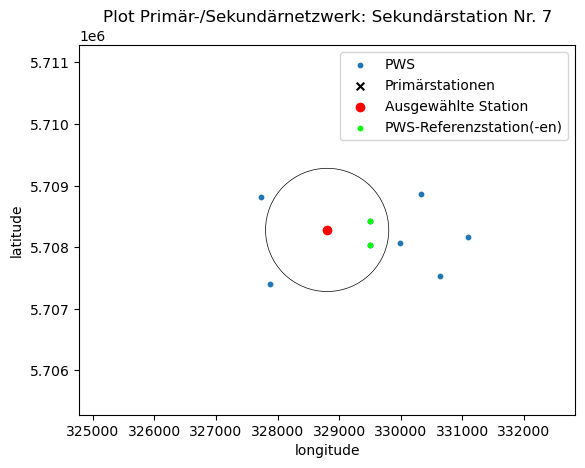

,7
NaNs gesamt,620011.0
NaN-Sequenzen,12307.0
1er und 2er NaN-Sequenzen,10565.0
Peaks,191.0
--------------------------------------------------,
NaNs nach Korrektur,604343.0
NaN-Sequenzen nach Korrektur,1668.0
1er und 2er NaN-Sequenzen nach Korrektur,612.0
Peaks nach Korrektur,1.0
--------------------------------------------------,


In [37]:
df_reference_stations, df_reference_values, data_corrected = correction_emscher_complete_mit_primary(coordinates_primary_utm32, coordinates_secondary_utm32, df_emscher, df_emscher_ref_nonan, df_emscher_nonan, 7, 3000, 1000, 0.99, True)
df_reference_stations
get_statistics_emscher(df_emscher, data_corrected)

In [38]:
# plt.plot(df_emscher[7])

In [39]:
# plt.plot(df_reference_values)

In [40]:
# plt.plot(data_corrected)

In [46]:
starts, peaks = ke.get_data_nan_seq_before_peak_new(df_emscher, 7, 0.9999)

In [47]:
starts

DatetimeIndex(['2018-04-30 06:10:00', '2020-02-09 23:30:00',
               '2020-08-17 17:20:00', '2021-06-21 01:30:00'],
              dtype='datetime64[ns]', freq=None)

In [48]:
peaks

DatetimeIndex(['2018-04-30 12:15:00', '2020-02-10 00:30:00',
               '2020-08-17 17:25:00', '2021-06-21 02:50:00'],
              dtype='datetime64[ns]', freq=None)

In [50]:
td = datetime.timedelta(minutes=5)

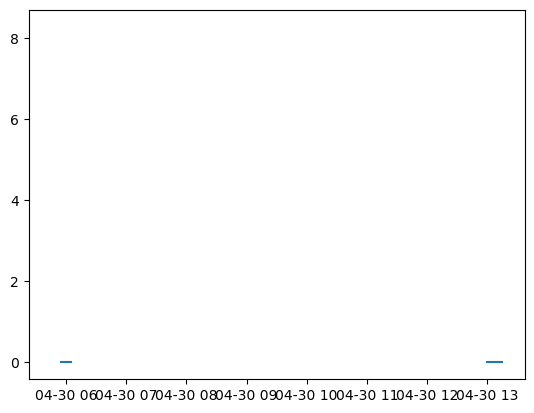

In [56]:
plt.plot(df_emscher[7].loc[starts[0] - 12*td:peaks[0] + 12*td])

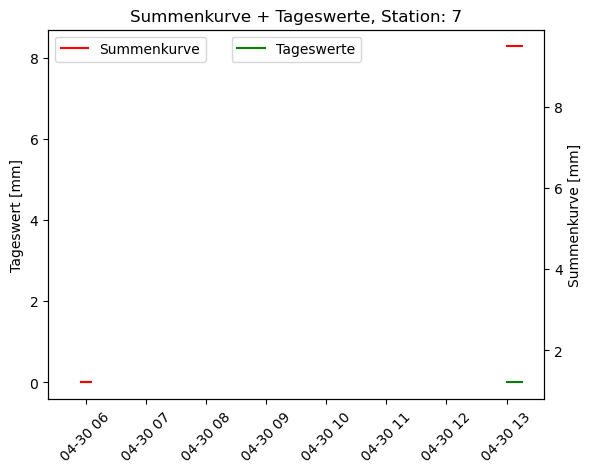

Gesamtniederschlag über Zeitraum: 9.49 mm



In [54]:
fct.sum_curve(df_emscher, 7, starts[0] - 12*td, peaks[0] + 12*td)

In [59]:
df_emscher[7].loc[peaks[0]]

8.28

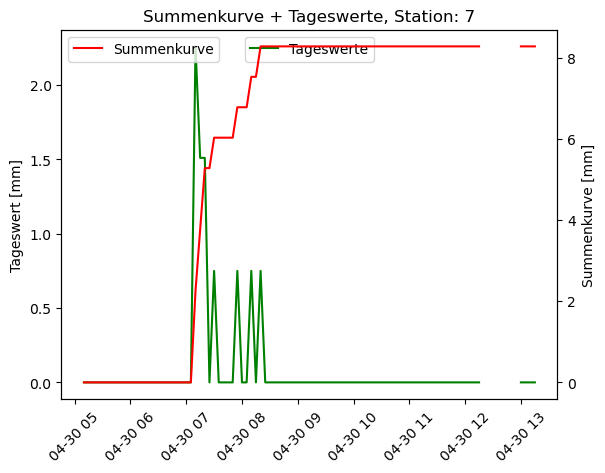

Gesamtniederschlag über Zeitraum: 8.28 mm



In [55]:
fct.sum_curve(data_corrected, 7, starts[0] - 12*td, peaks[0] + 12*td)